In [1]:
import scanpy as sc
import scvi
import numpy as np 
import pandas as pd
import torch.nn.functional as F

In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [44]:
# dataset_name = '10x-Multiome-Pbmc10k-small'
dataset_name = 'Chen-2019-small'
rna = sc.read(
    f"/ailab/user/liuxinyuan/projects/scmbench/datasets/{dataset_name}/{dataset_name}-RNA.h5ad",
)
atac = sc.read(
    f"/ailab/user/liuxinyuan/projects/scmbench/datasets/{dataset_name}/{dataset_name}-ATAC.h5ad",
)

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [46]:
rna_emb = pd.read_csv(f'/ailab/user/liuxinyuan/projects/scmbench/evaluation/UCE-zero-output/{dataset_name}/{dataset_name}-RNA_uce.csv',index_col=0,header=None)
rna_emb = rna_emb.values 
atac_emb = pd.read_csv(f'/ailab/user/liuxinyuan/projects/scmbench/evaluation/UCE-zero-output/{dataset_name}/{dataset_name}-ATAC_uce.csv',index_col=0,header=None)
atac_emb = atac_emb.values 

In [47]:
both=np.concatenate([rna_emb,atac_emb],axis=1)
adata = sc.concat([rna,atac],axis=1)
adata.obsm['X_scGPT'] = both
adata.obs['cell_type'] = rna.obs['cell_type']

In [51]:
class CustomSCVI(scvi.model.SCVI):
    def __init__(self, adata, input_key, **model_kwargs):
        super().__init__(adata, **model_kwargs)
        self.input_key = input_key

    def _get_inference_input(self, tensors):
        # 从 obsm 中获取输入数据
        x = self.adata.obsm[self.input_key]
        return dict(x=x)

    def _get_generative_input(self, tensors, inference_outputs):
        # 这里假设重构目标还是 X，可以调整为其他层或数据来源
        x = tensors["X"]
        return dict(x=x, z=inference_outputs["qz_m"])

    def _compute_reconstruction_loss(self, generative_outputs, target, **kwargs):
        # 自定义重构损失函数
        x_hat = generative_outputs["px_rate"]
        return F.mse_loss(x_hat, target)

CustomSCVI.setup_anndata(adata)

# 初始化自定义模型，input_key 为 obsm 中的键
model = CustomSCVI(adata, input_key="X_scGPT", n_layers=2, n_latent=30, gene_likelihood="nb")

model.train()

latent_representation = model.get_latent_representation()

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ailab/user/liuxinyuan/.conda/envs/perturb/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ailab/user/liuxinyuan/.conda/envs/perturb/lib/pytho ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Epoch 400/400: 100%|██████████| 400/400 [08:57<00:00,  1.34s/it, v_num=1, train_loss_step=4.39e+3, train_loss_epoch=4.3e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:57<00:00,  1.34s/it, v_num=1, train_loss_step=4.39e+3, train_loss_epoch=4.3e+3]


In [52]:
output_rna_dir=f'/ailab/user/liuxinyuan/projects/scmbench/save/uce_scVI_30/{dataset_name}-rna2.csv'
output_atac_dir=f'/ailab/user/liuxinyuan/projects/scmbench/save/uce_scVI_30/{dataset_name}-atac2.csv'

pd.DataFrame(latent_representation, index=adata.obs_names).to_csv(output_rna_dir, header=False)
pd.DataFrame(latent_representation, index=adata.obs_names).to_csv(output_atac_dir, header=False)


In [53]:
adata.obsm['X_gpt_scVI'] = latent_representation

In [ ]:
sc.pp.neighbors(adata, use_rep="X_gpt_scVI")
sc.tl.umap(adata, min_dist=0.3)

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


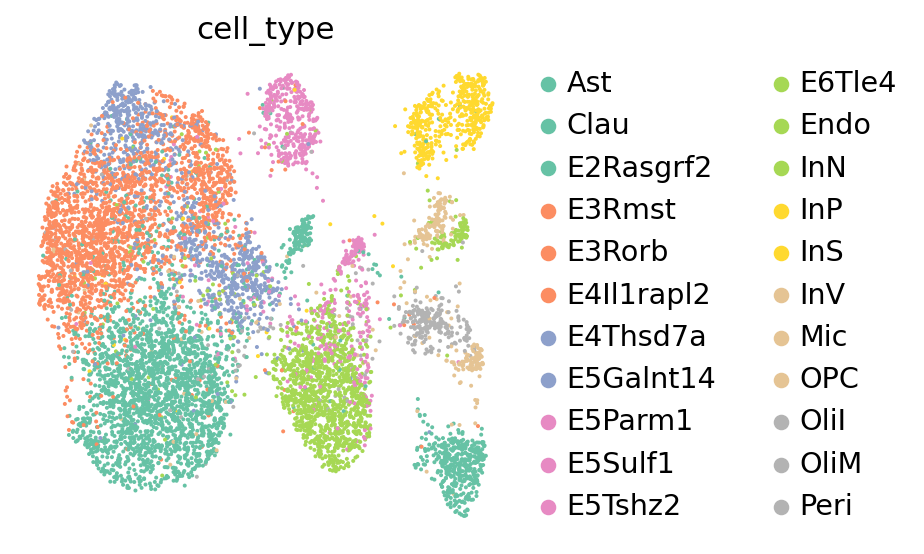

In [56]:
sc.pp.neighbors(adata, use_rep="X_gpt_scVI")
sc.tl.umap(adata, min_dist=0.3)
fig = sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
)

In [42]:
fig.savefig(
            f'/ailab/user/liuxinyuan/projects/scmbench/save/uce_scVI_30/embeddings_celltype_umap2.png', dpi=300, bbox_inches="tight"
        )

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


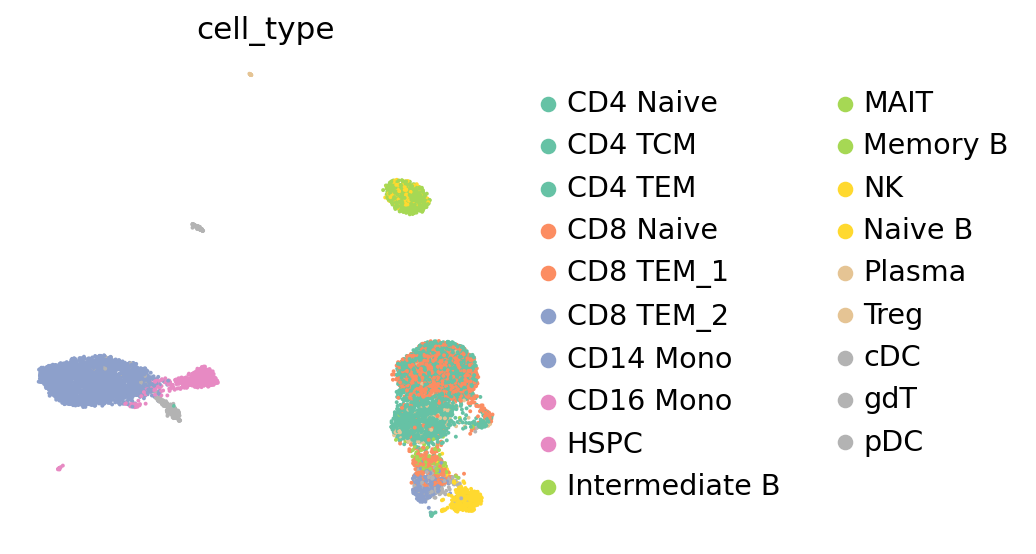

In [25]:
sc.pp.neighbors(adata, use_rep="X_scGPT")
sc.tl.umap(adata, min_dist=0.3)
fig = sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
)

In [26]:
fig.savefig(
            f'/ailab/user/liuxinyuan/projects/scmbench/evaluation/scGPT-zero-output/{dataset_name}/embeddings_celltype_blood_umap.png', dpi=300, bbox_inches="tight"
        )

In [33]:
rna_emb = pd.read_csv(f'/ailab/user/liuxinyuan/projects/scmbench/save/nopre_blood_SCMBench-Sep04-12-30/{dataset_name}-rna.csv',index_col=0,header=None)
rna_emb = rna_emb.values 
adata.obsm['X_pre'] = rna_emb

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


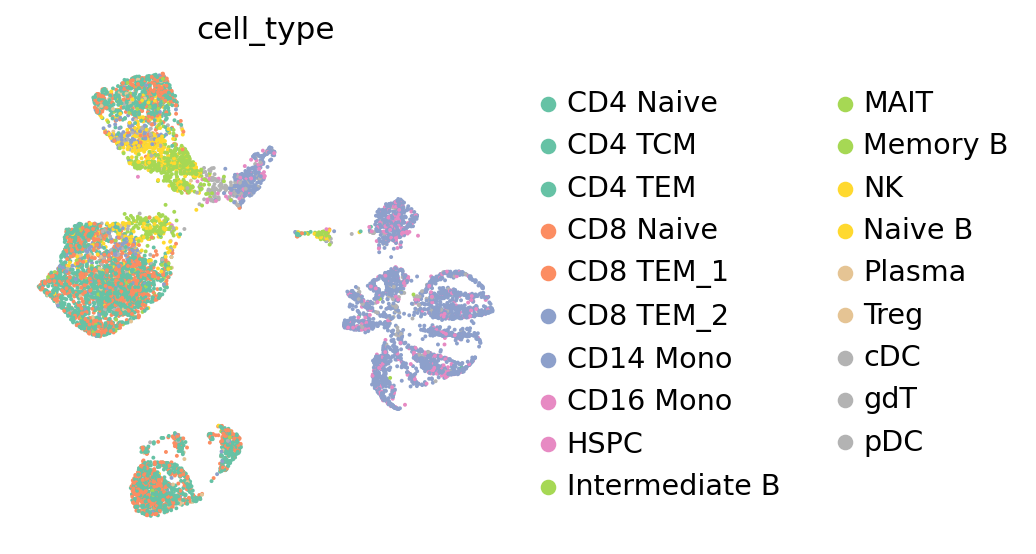

In [34]:
sc.pp.neighbors(adata, use_rep="X_pre")
sc.tl.umap(adata, min_dist=0.3)
fig = sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
    palette='Set2',
)

In [35]:
fig.savefig(
            f'/ailab/user/liuxinyuan/projects/scmbench/save/nopre_blood_SCMBench-Sep04-12-30/embeddings_celltype_umap.png', dpi=300, bbox_inches="tight"
        )

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


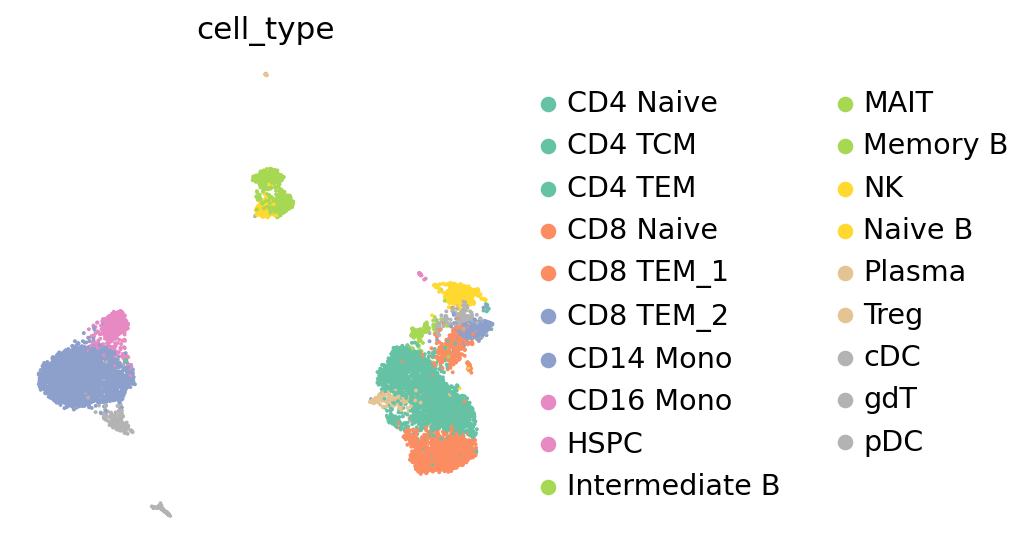

In [26]:
sc.pp.neighbors(adata, use_rep="X_pre")
sc.tl.umap(adata, min_dist=0.3)
fig = sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
    palette='Set2',
)

In [27]:
fig.savefig(
            f'/ailab/user/liuxinyuan/projects/scmbench/save/scGPT_scVI_30/embeddings_celltype_umap.png', dpi=300, bbox_inches="tight"
        )

In [28]:
rna_emb = pd.read_csv('/ailab/user/liuxinyuan/projects/scmbench/evaluation/scGPT-zero-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-human-rna.csv',index_col=0,header=None)
atac_emb = pd.read_csv('/ailab/user/liuxinyuan/projects/scmbench/evaluation/scGPT-zero-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-human-atac.csv',index_col=0,header=None)

In [34]:
both = np.concatenate([rna_emb.values,atac_emb.values],axis=1)

In [35]:
both.shape

(9631, 1024)

In [36]:
adata.obsm['X_pre'] = both

/ailab/user/liuxinyuan/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


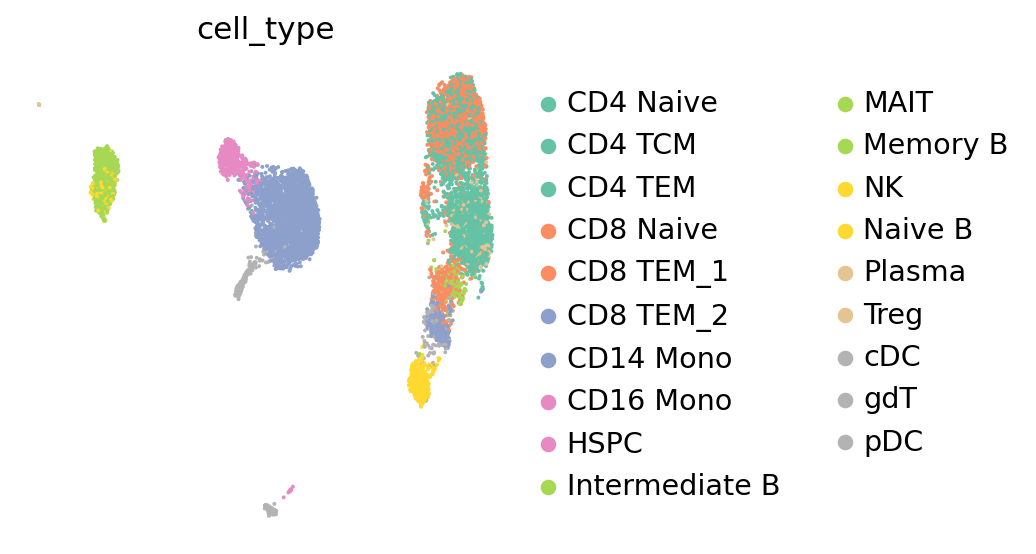

In [37]:
sc.pp.neighbors(adata, use_rep="X_pre")
sc.tl.umap(adata, min_dist=0.3)
fig = sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
    palette='Set2',
)

In [38]:
fig.savefig(
            f'/ailab/user/liuxinyuan/projects/scmbench/evaluation/scGPT-zero-output/10x-Multiome-Pbmc10k-small/embeddings_celltype_umap.png', dpi=300, bbox_inches="tight"
        )